In [26]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
from scipy.optimize import minimize

def generate_ansatz(noq, qc, angle):
    depth = noq
    off = 0
    for j in range(depth):
        for i in range(noq):
            qc.ry(angle[off + i], i)
            if (i != 0 and j != (depth - 1)):
                qc.cz(0,i)
        off += i+1
def append_A_matrix(qc, gate, ancilla, start = 0, end = 0):
    if (end == 0):
        end = len(gate)
    for i in range(start, end):
        if (gate[i - start] == 1):
            qc.cx(ancilla, i)
        if (gate[i - start] == 2):
            qc.cy(ancilla, i)   
        if (gate[i - start] == 3):
            qc.cz(ancilla, i)    

def generate_B(noq, qc, b):
    qc.initialize(b, range(noq))
    
import numpy as np
I = np.asmatrix('1 0;0 1')
X = np.asmatrix('0 1;1 0')
Y = np.asmatrix('0 0-1j;0+1j 0')
Z = np.asmatrix('1 0;0 -1')
pauli_i = [I, 0]
pauli_x = [X, 1]
pauli_y = [Y, 2]
pauli_z = [Z, 3]

def get_basis_set(num_of_qubit = 1):
    basis_set = [pauli_i, pauli_x, pauli_y, pauli_z]
    int_set = [pauli_i, pauli_x, pauli_y, pauli_z]
    temp_set = []
    for i in range (num_of_qubit-1):
        for j in range (len(basis_set)):
            for k in range (len(int_set)):
                a = basis_set[j]
                b = int_set[k]
                #temp_set.append()
                temp_set.append([np.kron(a[0],b[0]),[a[1],b[1]]])
        int_set = temp_set
        #print(int_set)
        temp_set = []
    return int_set

def get_decomposition(A, num_of_q):
    basis = get_basis_set(num_of_q)
    dec_list = []
    for i in range(len(basis)):
        b = basis[i]
        coeff = np.trace(A*b[0])/(2**num_of_q)
        dec_list.append([coeff, b[1]])
    return dec_list
def get_arbitary_decomposition(A):
    size = A.shape
    size = size[0]
    power = math.log2(size)
    p = int(power)
    if (p != power):
        p += 1
    ret = np.zeros([2**p,2**p], dtype = float)
    ret[:size, :size] = A
    for i in range(size, 2**p):
        ret[i,i] = 1
    return get_decomposition(ret, p)
def hadamard_test_num(noq, qc, angle, ancilla, reg, gate, b):
        qc.h(ancilla)
        qc.barrier()
        generate_control_ansatz(noq, qc, angle, ancilla, reg)
        qc.barrier()
        append_A_matrix(qc, gate, ancilla)
        qc.barrier()
        qc.ch(ancilla, 0)
        qc.ch(ancilla, 1)
        qc.barrier()
        qc.h(ancilla)
def had_test_a(qc, ancilla_index, gat, gat_trans, noq, angle, bIm = False):
    qc.h(ancilla_index)
    if (bIm):
        qc.sdg(ancilla_index)
    generate_ansatz(noq, qc, angle)
    append_A_matrix(qc, gat, ancilla_index)
    append_A_matrix(qc, gat_trans, ancilla_index)
    qc.h(ancilla_index)
    
def generate_control_ansatz(noq, qc, angle, ancilla, reg):
    depth = noq
    off = 0
    for j in range(depth):
        for i in range(noq):
            qc.cry(angle[i+off], qiskit.circuit.Qubit(reg,ancilla), qiskit.circuit.Qubit(reg, i))
            if (i != 0 and j != (depth - 1)):
                qc.h(j)
                qc.ccx(ancilla, i, j)
                qc.h(j)
        off += i+1

In [38]:
a = np.matrix('1 2 3 4; 2 5 1 3; 3 1 6 2; 4 3 2 7')
b = [0.7071067, 0.7071067, 0.7071067, 0.7071067]
d = np.linalg.norm(b)
a = a/(10)#/(d)#*np.linalg.norm(a))
b = b/d
print(np.linalg.norm(b), np.linalg.norm(a))
dec_list = get_arbitary_decomposition(a)
gate = []
coeff = []
for i in range(len(dec_list)):
    if (abs(dec_list[i][0]) != 0):
        coeff.append(dec_list[i][0])
        gate.append(dec_list[i][1])
print(coeff)
print(len(coeff))
def calculate_cost(angle):  
    shots = 200000
    T = shots
    denom = 0
    numer = 0
    cof = 0
    noq = 2
    backend = Aer.get_backend('qasm_simulator')
    #print(gate)
    #print(coeff)
    for i in range(len(coeff)):
        for k in range(len(coeff)):
            circ = QuantumCircuit(noq + 1,1)
            cof = coeff[i]*np.conj(coeff[k])
            had_test_a(circ, noq, gate[i], gate[k], noq, angle)
            circ.measure(noq, 0)
            job = execute(circ, backend=backend, shots=shots,max_credits=3)    
            result = job.result()
            counts = result.get_counts(circ)
            m_sum = 0
            if "0" in list (counts):
                m_sum=m_sum+counts["0"]/T
            if "1" in list (counts):
                m_sum=m_sum-counts["1"]/T
            denom += cof*m_sum
    
    for i in range(len(coeff)):
        qc1 = QuantumRegister(noq + 1)
        cr = ClassicalRegister(1)
        qc = QuantumCircuit(qc1, cr)
        hadamard_test_num(noq, qc, angle, noq, qc1, gate[i], b)
        qc.measure(noq, 0)
        #print(qc)
        job = execute(qc, backend=backend, shots=shots,max_credits=3)    
        result = job.result()
        counts = result.get_counts(qc)
        m_sum_i = 0
        if "0" in list (counts):
            m_sum_i=m_sum_i+counts["0"]/T
        if "1" in list (counts):
            m_sum_i=m_sum_i-counts["1"]/T
        
        for j in range(len(coeff)):
            qc1 = QuantumRegister(noq + 1)
            cr = ClassicalRegister(1)
            qc = QuantumCircuit(qc1, cr)
            hadamard_test_num(noq, qc, angle, noq, qc1, gate[j], b)
            qc.measure(noq, 0)
            #print(qc)
            job = execute(qc, backend=backend, shots=shots,max_credits=3)    
            result = job.result()
            counts = result.get_counts(qc)
            m_sum = 0
            #print(counts)
            if "0" in list (counts):
                m_sum=m_sum+counts["0"]/T
            if "1" in list (counts):
                m_sum=m_sum-counts["1"]/T
            numer += m_sum*m_sum_i*(coeff[i]*np.conj(coeff[j]))
    print("numer = "+str(numer)+" denom= "+str(denom)+"cost = "+str(1-(numer/denom))+" angle = "+ str(angle))
    
    return abs(1-(numer/denom))  
angle = [4.71238891, 4.71238899, 2.30352528, 3.33615899]
maxiter = 2000000
iters = 0 
threshold = 0.00000047
k=0
out = minimize(calculate_cost, x0=angle, method="cobyla", options={'maxiter':200},tol = threshold)
print(out)

1.0 1.40356688476182
[0.475, 0.2, -0.125, 0.3, 0.25, (-0.15000000000000002+0j), -0.175, -0.07500000000000001]
8
numer = (0.6744434294486876+0j) denom= (0.6767459250000001+0j)cost = (0.0034023042714479423+0j) angle = [4.71238891 4.71238899 2.30352528 3.33615899]
numer = (1.3261509628687493+0j) denom= (1.3520195750000001+0j)cost = (0.019133311831857736+0j) angle = [5.71238891 4.71238899 2.30352528 3.33615899]
numer = (0.6755711217324377+0j) denom= (0.7282010687500002+0j)cost = (0.07227392169020685+0j) angle = [4.71238891 5.71238899 2.30352528 3.33615899]
numer = (0.40886508547018763+0j) denom= (0.42367371249999997+0j)cost = (0.034952905013695745+0j) angle = [4.71238891 4.71238899 3.30352528 3.33615899]
numer = (0.4070135815506875+0j) denom= (0.42373243749999995+0j)cost = (0.03945616259154683+0j) angle = [4.71238891 4.71238899 2.30352528 4.33615899]
numer = (0.35398812531874996+0j) denom= (0.41536461249999995+0j)cost = (0.14776532553372013+0j) angle = [4.52809567 3.90553834 1.93390099 2.9

numer = (0.6730258106171879+0j) denom= (0.6756592874999998+0j)cost = (0.0038976403218787814+0j) angle = [4.62877047 4.85297826 2.16158347 3.02826977]
numer = (0.6718100971929376+0j) denom= (0.6767448250000001+0j)cost = (0.007291858947074292+0j) angle = [4.62877189 4.85297804 2.16158181 3.02826961]
numer = (0.6734511400158124+0j) denom= (0.6762999874999999+0j)cost = (0.0042124020949910745+0j) angle = [4.62877201 4.85297787 2.16158271 3.0282688 ]
numer = (0.6749301507944377+0j) denom= (0.6771245124999995+0j)cost = (0.0032407063472861264+0j) angle = [4.62877164 4.85297789 2.16158233 3.02826883]
numer = (0.6737560031370623+0j) denom= (0.67713955625+0j)cost = (0.004996832752875768+0j) angle = [4.62877142 4.85297762 2.16158268 3.02826917]
     fun: 0.004996832752875768
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 60
  status: 1
 success: True
       x: array([4.62877142, 4.85297762, 2.16158268, 3.02826917])


[-0.1752 +0.j  0.6285 +0.j  0.74199+0.j  0.15407+0.j]


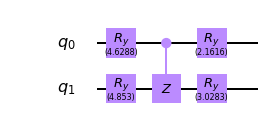

In [39]:
circ = QuantumCircuit(2)
generate_ansatz(2, circ, out.x)
circ.draw(output="mpl")
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
outputstate = result.get_statevector(circ, decimals=5)
print(outputstate)
circ.draw(output="mpl")

In [33]:
b = [1, 0, 0, 0]
b = b/np.linalg.norm(b)
print(b)
circ = QuantumCircuit(2)
circ.initialize(b, range(0,2))
circ.draw(output='mpl')
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
outputstate = result.get_statevector(circ, decimals=5)
print(outputstate)

[1. 0. 0. 0.]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [36]:
a = np.matrix('1 2 3 4; 2 5 1 3; 3 1 6 2; 4 3 2 7')
b = [0.7071067, 0.7071067, 0.7071067, 0.7071067]
d = np.linalg.norm(b)
a = a/(10)#/(d)#*np.linalg.norm(a))
b = b/d
print(np.linalg.norm(b), np.linalg.norm(a))
dec_list = get_arbitary_decomposition(a)
gate = []
coeff = []
for i in range(len(dec_list)):
    if (abs(dec_list[i][0]) != 0):
        coeff.append(dec_list[i][0])
        gate.append(dec_list[i][1])
print(coeff)
print(len(coeff))
def calculate_cost(angle):  
    shots = 200000
    T = shots
    denom = 0
    numer = 0
    cof = 0
    noq = 2
    backend = Aer.get_backend('statevector_simulator')
    #print(gate)
    #print(coeff)
    for i in range(len(coeff)):
        for k in range(len(coeff)):
            circ = QuantumCircuit(noq + 1,1)
            cof = coeff[i]*np.conj(coeff[k])
            had_test_a(circ, noq, gate[i], gate[k], noq, angle)
            #circ.measure(noq, 0)
            job = execute(circ, backend)
            result = job.result()
            outputstate = result.get_statevector(circ, decimals=100)
            o = outputstate
            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = float(o[l])**2
                    m_sum+=n
            denom += cof*(1-(2*m_sum))
    
    for i in range(len(coeff)):
        qc1 = QuantumRegister(noq + 1)
        cr = ClassicalRegister(1)
        qc = QuantumCircuit(qc1, cr)
        hadamard_test_num(noq, qc, angle, noq, qc1, gate[i], b)
        #qc.measure(noq, 0)
        #print(qc)
        job = execute(qc, backend)
        result = job.result()
        outputstate = result.get_statevector(qc, decimals=100)
        o = outputstate
        m_sum_i = 0
        for l in range (0, len(o)):
            if (l%2 == 1):
                n = float(o[l])**2
                m_sum_i+=n
        
        for j in range(len(coeff)):
            qc1 = QuantumRegister(noq + 1)
            cr = ClassicalRegister(1)
            qc = QuantumCircuit(qc1, cr)
            hadamard_test_num(noq, qc, angle, noq, qc1, gate[j], b)
            #qc.measure(noq, 0)
            #print(qc)
            job = execute(qc, backend)
            result = job.result()
            outputstate = result.get_statevector(qc, decimals=100)
            o = outputstate
            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = float(o[l])**2
                    m_sum+=n
            numer += (1-(2*m_sum))*(1-(2*m_sum_i))*(coeff[i]*np.conj(coeff[j]))
    print("numer = "+str(numer)+" denom= "+str(denom)+"cost = "+str(1-(numer/denom))+" angle = "+ str(angle))
    
    return abs(1-(numer/denom))  
angle = [3.71238891, 3.71238899, 2.30352528, 3.33615899]
maxiter = 2000000
iters = 0 
threshold = 0.00000047
k=0
out = minimize(calculate_cost, x0=angle, method="cobyla", options={'maxiter':200},tol = threshold)
print(out)

1.0 1.40356688476182
[0.475, 0.2, -0.125, 0.3, 0.25, (-0.15000000000000002+0j), -0.175, -0.07500000000000001]
8


c:\users\hrush\.conda\envs\quantum_computing\lib\site-packages\ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\hrush\.conda\envs\quantum_computing\lib\site-packages\ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\hrush\.conda\envs\quantum_computing\lib\site-packages\ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


numer = (0.12249997590833019+0j) denom= (1.3556981262596866e-08+0j)cost = (-9035932.113391725+0j) angle = [4.71238891 4.71238899 2.30352528 3.33615899]
numer = (0.6709767309779391+0j) denom= (-0.14071512440017836+0j)cost = (5.7683341349274935+0j) angle = [5.71238891 4.71238899 2.30352528 3.33615899]
numer = (1.0966652201951117+0j) denom= (-0.056224133683607465+0j)cost = (20.505239980511288+0j) angle = [5.71238891 5.71238899 2.30352528 3.33615899]
numer = (0.06162798938035181+0j) denom= (-0.20761560884079952+0j)cost = (1.2968369754299562+0j) angle = [5.71238891 4.71238899 3.30352528 3.33615899]
numer = (0.06162798938035188+0j) denom= (-0.2076156088407996+0j)cost = (1.2968369754299565+0j) angle = [5.71238891 4.71238899 3.30352528 4.33615899]
numer = (0.05762327048937574+0j) denom= (-0.22435041057974944+0j)cost = (1.256844952235523+0j) angle = [6.71238891 4.71238736 3.30352577 3.33615899]
numer = (0.07914338486663682+0j) denom= (-0.23108072850124234+0j)cost = (1.3424923635127424+0j) angle

numer = (5.312651013989617e-09+0j) denom= (-0.18836960405829764+0j)cost = (1.0000000282033348+0j) angle = [6.76880358 4.83534827 3.63138432 3.34273081]
numer = (9.45419748998172e-10+0j) denom= (-0.18835777959462632+0j)cost = (1.0000000050192763+0j) angle = [6.76873778 4.83542708 3.63151415 3.34277603]
numer = (1.883253665860285e-11+0j) denom= (-0.18835794504656594+0j)cost = (1.0000000000999827+0j) angle = [6.76877745 4.83543445 3.63146994 3.34274326]
numer = (1.2151408720385837e-09+0j) denom= (-0.18836530954955552+0j)cost = (1.0000000064509802+0j) angle = [6.76878078 4.83540273 3.63141832 3.34274991]
numer = (1.660438089107208e-10+0j) denom= (-0.18835407186562644+0j)cost = (1.0000000008815515+0j) angle = [6.76879365 4.83544306 3.63148305 3.34272269]
numer = (1.7822277074280857e-11+0j) denom= (-0.1883594843324562+0j)cost = (1.0000000000946183+0j) angle = [6.76876625 4.83543483 3.63146768 3.34273316]
numer = (4.087069849223468e-10+0j) denom= (-0.18835837314871554+0j)cost = (1.00000000216